# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


In [11]:
%matplotlib inline

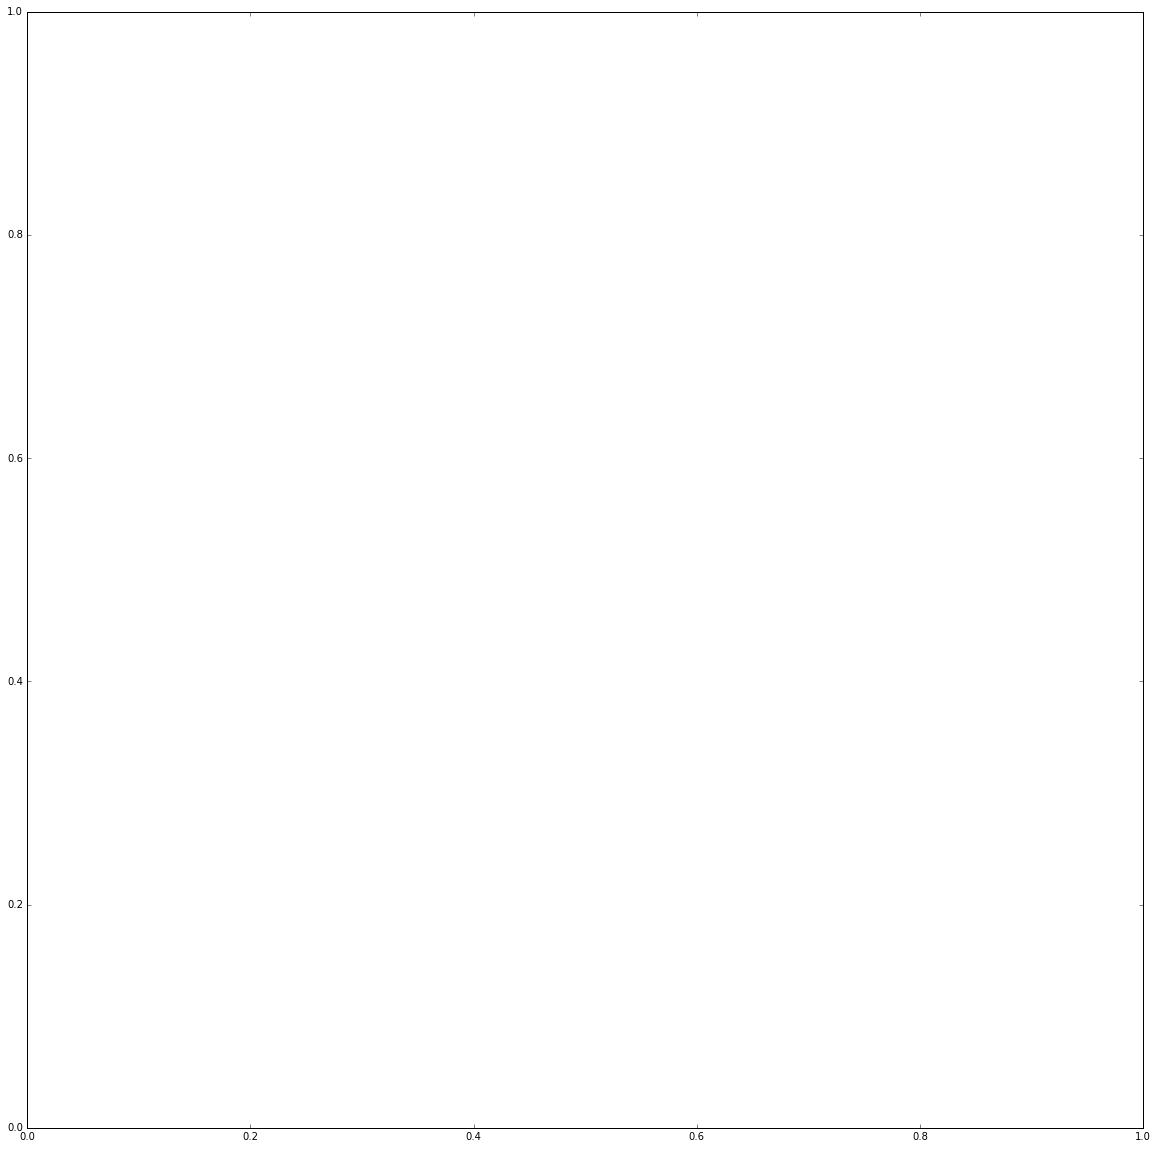

In [12]:
fig, ax = plt.subplots(figsize = (20,20))


In [13]:
correlations.sort_values()


frl_percent                            -0.722225
sped_percent                           -0.448170
ell_percent                            -0.398750
hispanic_per                           -0.396985
black_per                              -0.284139
ell_num                                -0.153778
lon                                    -0.132222
lat                                    -0.121029
com_p_11                               -0.115073
male_per                               -0.112062
zip                                    -0.063977
rr_t                                   -0.023386
eng_p_11                                0.020254
hispanic_num                            0.025744
black_num                               0.027979
sped_num                                0.034933
aca_p_11                                0.035155
eng_t_11                                0.036906
CSD                                     0.042948
rr_p                                    0.047925
com_tot_11          

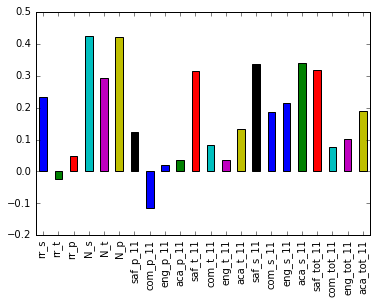

In [14]:
correlations[survey_fields].plot.bar()

I found it surprising that there's such a strong correlation between sat scores and safety/respect scores and academic expectations scores.

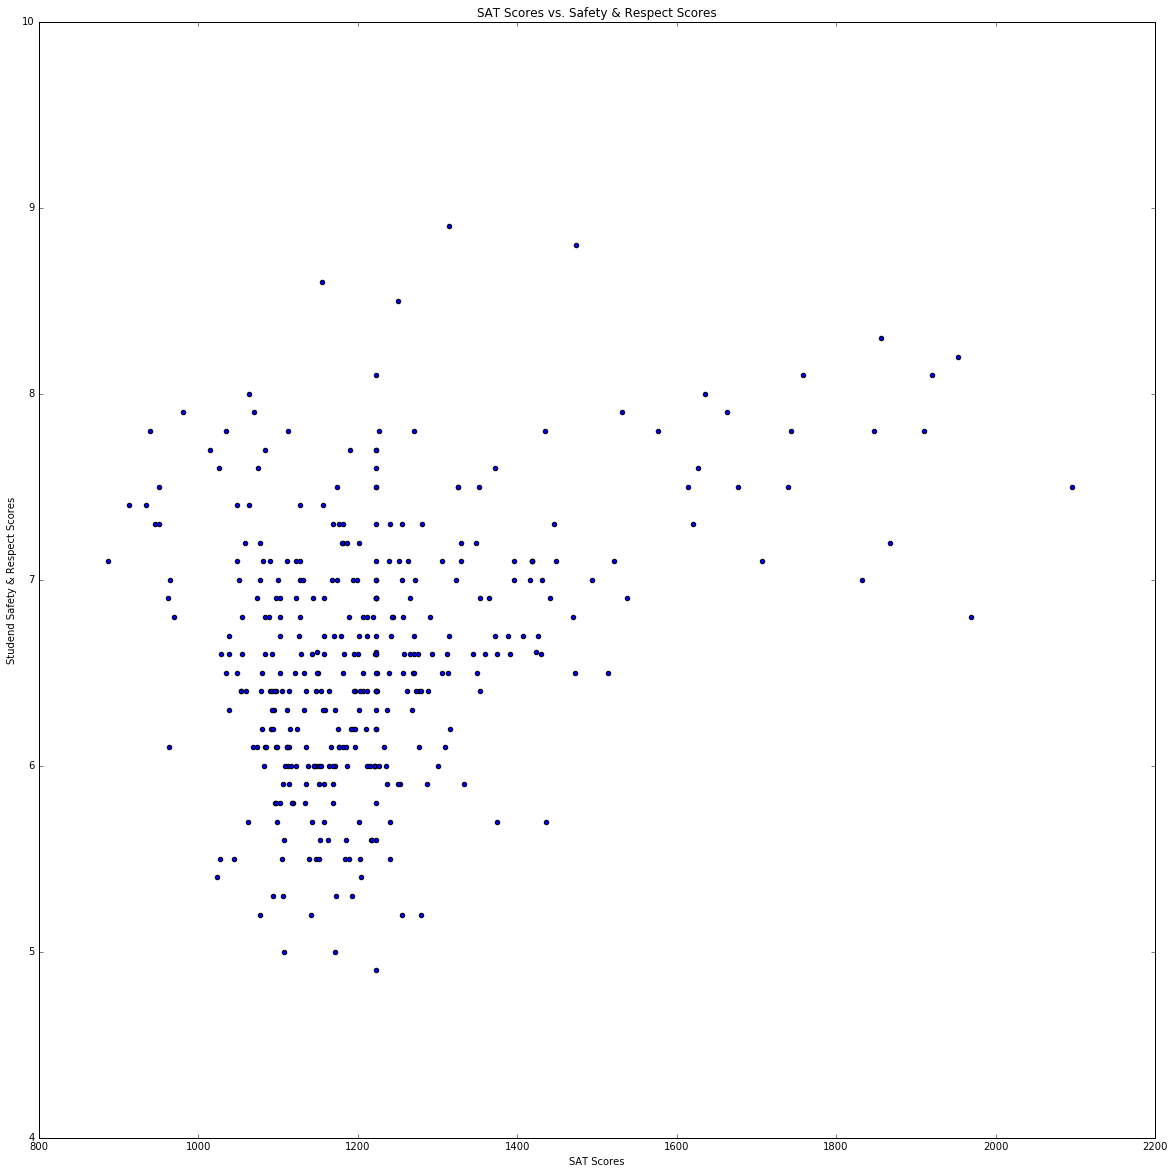

'I can see a positive correlation between the two variables.'

In [15]:
fig, ax = plt.subplots(figsize = (20,20))
ax.scatter(combined['sat_score'], combined['saf_s_11'])
ax.set_xlabel('SAT Scores')
ax.set_ylabel('Studend Safety & Respect Scores')
ax.set_title('SAT Scores vs. Safety & Respect Scores')
plt.show()

"""I can see a positive correlation between the two variables."""

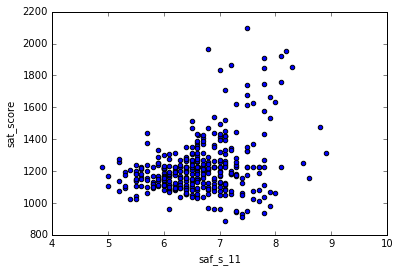

In [16]:
"""Doing the same chart with different method:"""

combined.plot.scatter('saf_s_11', 'sat_score')

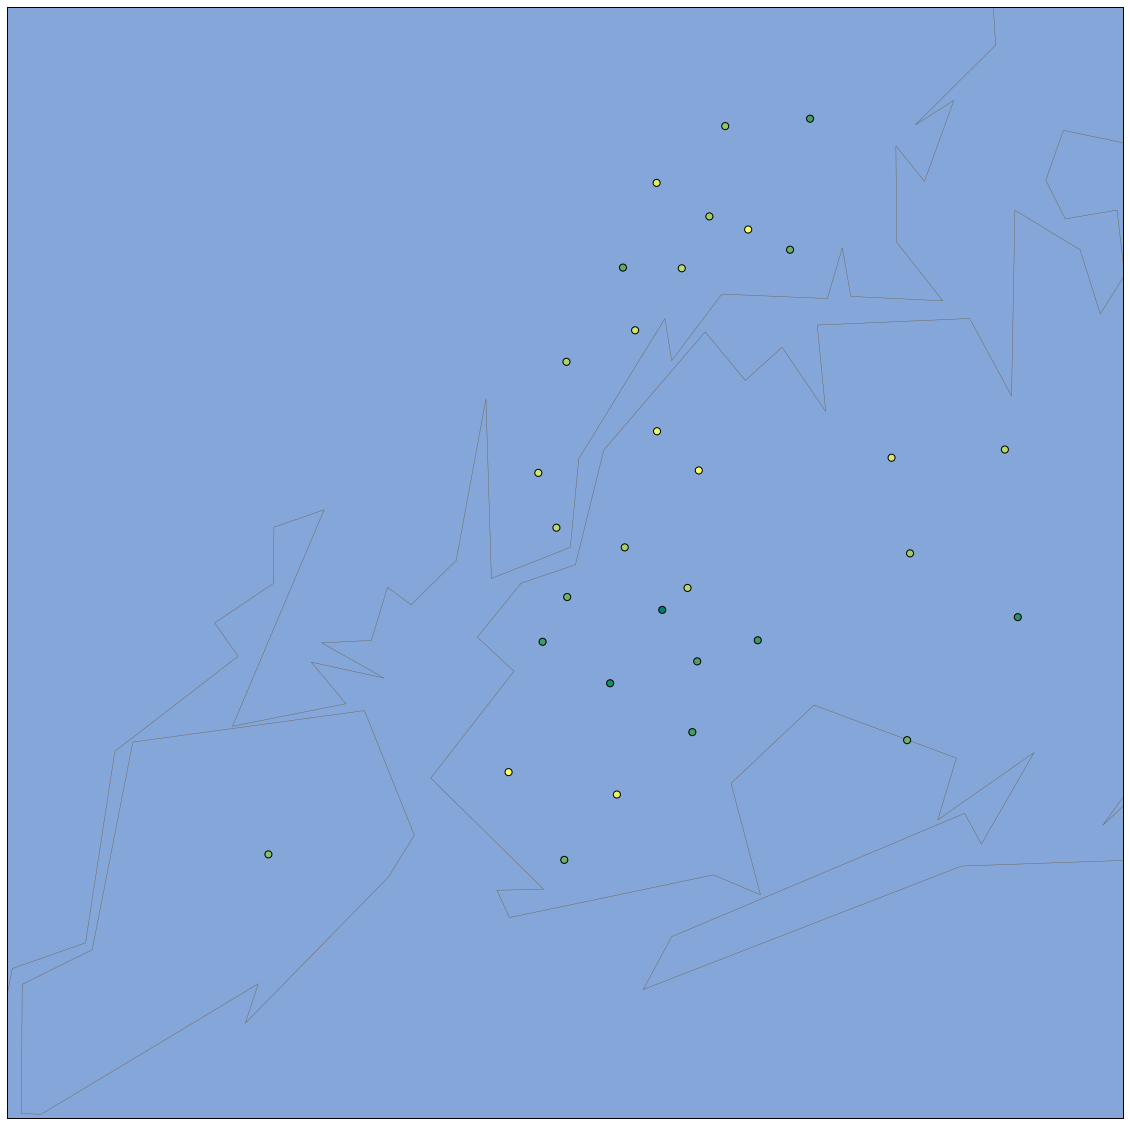

In [17]:
import numpy as np
by_dist = combined.groupby('school_dist').agg(np.mean)
by_dist.reset_index(inplace=True)
import os

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(20,20))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = by_dist['lon'].tolist()
latitudes = by_dist['lat'].tolist()
(m.scatter(longitudes, latitudes, s=50, zorder = 2, latlon = True, 
           c = by_dist['saf_s_11'], cmap = 'summer'))
plt.show()

In [18]:
"""Green areas are higher safety scores, yellow ones are lower. There seem
to be clusters of both."""

'Green areas are higher safety scores, yellow ones are lower. There seem\nto be clusters of both.'

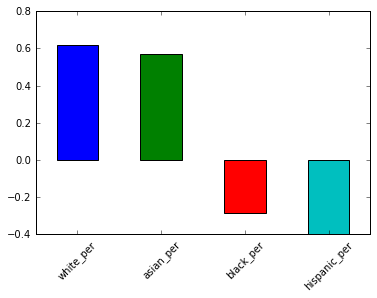

In [19]:
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot.bar(rot=45)


In [20]:
#I was surprised to see such a stark contrast between different racial groups'
#correlation scores.

In [28]:
hisp_schools = combined[combined['hispanic_per'] > 95.0]
print(hisp_schools[['SCHOOL NAME','sat_score']])

                                           SCHOOL NAME  sat_score
44                       MANHATTAN BRIDGES HIGH SCHOOL     1058.0
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL     1174.0
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...     1014.0
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY      951.0
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS      934.0
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE      970.0
253                          MULTICULTURAL HIGH SCHOOL      887.0
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL      951.0


In [31]:
hisp_schools['sat_score'].describe()

count       8.000000
mean      992.375000
std        89.600602
min       887.000000
25%       946.750000
50%       960.500000
75%      1025.000000
max      1174.000000
Name: sat_score, dtype: float64

In [36]:
non_hisp_schools = combined[combined['hispanic_per'] < 10.0]
non_hisp_schools = non_hisp_schools[non_hisp_schools['sat_score'] > 1800]
print(non_hisp_schools[['SCHOOL NAME','sat_score']])

                                           SCHOOL NAME  sat_score
37                              STUYVESANT HIGH SCHOOL     2096.0
151                       BRONX HIGH SCHOOL OF SCIENCE     1969.0
187                     BROOKLYN TECHNICAL HIGH SCHOOL     1833.0
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...     1868.0
356                STATEN ISLAND TECHNICAL HIGH SCHOOL     1953.0


In [32]:
non_hisp_schools['sat_score'].describe()

count      30.000000
mean     1318.414627
std       310.132878
min       963.000000
25%      1113.500000
50%      1180.500000
75%      1411.250000
max      2096.000000
Name: sat_score, dtype: float64

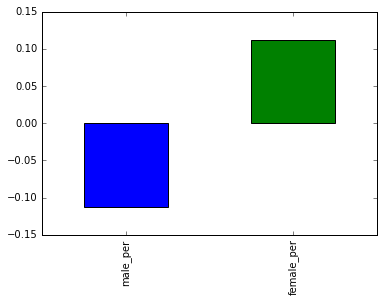

In [39]:
gender = correlations[['male_per','female_per']]
gender.plot.bar()

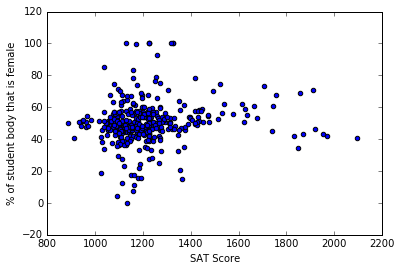

In [45]:
fig, ax = plt.subplots()
plt.scatter(combined['sat_score'], combined['female_per'])
ax.set_xlabel('SAT Score')
ax.set_ylabel('% of student body that is female')

In [48]:
hi_fem_hi_sat = (combined['sat_score'] > 1700) & (combined['female_per'] > 60)
print(combined[hi_fem_hi_sat]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [49]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

In [50]:
combined['ap_per'].head()

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64

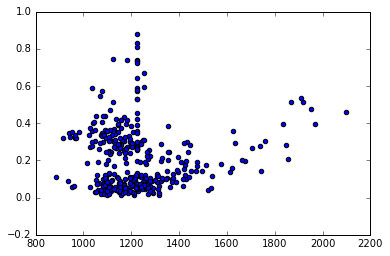

In [52]:
plt.scatter(combined['sat_score'], combined['ap_per'])